In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from scipy import ndimage
from scipy import linalg
from skimage.util.shape import view_as_windows
import random
import math
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import io
import radiomics
from enum import Enum
from radiomics.glcm import RadiomicsGLCM
import SimpleITK as sitk
import imageio
from itertools import product

In [2]:
# Read sample data.
img_s = sitk.ReadImage('../sample_data/ImageSlice.jpg')
mask_s = sitk.ReadImage('../sample_data/ImageMask.jpg')

In [3]:
# Turn image into a Numpy array.
img_array = sitk.GetArrayFromImage(img_s)
print(f'IMAGE:\nwidth={img_array.shape[0]} height={img_array.shape[1]}')

IMAGE:
width=440 height=596


In [4]:
class HaralickFeature(Enum):
    JointEntropy = ('JointEntropy', RadiomicsGLCM.getJointEntropyFeatureValue)
    JointEnergy = ('JointEnergy', RadiomicsGLCM.getJointEnergyFeatureValue)
    SumSquares = ('SumSquares', RadiomicsGLCM.getSumSquaresFeatureValue)
    Idm = ('Idm', RadiomicsGLCM.getIdmFeatureValue)
    Correlation = ('Correlation', RadiomicsGLCM.getCorrelationFeatureValue)
    Imc1 = ('Imc1', RadiomicsGLCM.getImc1FeatureValue)
    Imc2 = ('Imc2', RadiomicsGLCM.getImc2FeatureValue)
    SumAverage = ('SumAverage', RadiomicsGLCM.getSumAverageFeatureValue)
    ClusterTendency = ('ClusterTendency', RadiomicsGLCM.getClusterTendencyFeatureValue)
    SumEntropy = ('SumEntropy', RadiomicsGLCM.getSumEntropyFeatureValue)
    DifferenceAverage = ('DifferenceAverage', RadiomicsGLCM.getDifferenceAverageFeatureValue)
    DifferenceVariance = ('DifferenceVariance', RadiomicsGLCM.getDifferenceVarianceFeatureValue)
    DifferenceEntropy = ('DifferenceEntropy', RadiomicsGLCM.getDifferenceEntropyFeatureValue)

In [5]:
desired_haralick_feature = HaralickFeature.JointEntropy

In [6]:
# Create random window.
patch_window_size = random.randint(50, 150)
haralick_window_size = random.randint(5, 20)
mask_center_x, mask_center_y = random.randint(patch_window_size, img_array.shape[1] - patch_window_size), random.randint(patch_window_size, img_array.shape[0] - patch_window_size)
print(f'WINDOW:\nCenter: x={mask_center_x} y={mask_center_y}; Size: width={patch_window_size} height={patch_window_size}')
mask_min_x = int(mask_center_x - patch_window_size/2)
mask_min_y = int(mask_center_y - patch_window_size/2)
mask_max_x = mask_min_x + patch_window_size
mask_max_y = mask_min_y + patch_window_size

WINDOW:
Center: x=220 y=308; Size: width=110 height=110


In [7]:
def show_colored_image(figure, axis, image_data, colormap=plt.cm.jet):
    image = axis.imshow(image_data, cmap=colormap)
    divider = make_axes_locatable(axis)
    colorbar_axis = divider.append_axes("right", size="5%", pad=0.05)
    figure.colorbar(image, cax=colorbar_axis)

def create_highlighted_rectangle(x, y, w, h):
    return Rectangle((x, y), w, h, linewidth=3, edgecolor='cyan', facecolor='none')

def highlight_rectangle_on_image(image_data, min_x, min_y, w, h, colormap=plt.cm.gray):
    figure, axes = plt.subplots(1,2, figsize=(15,15))

    # Highlight window within image.
    show_colored_image(figure, axes[0], image_data, colormap)
    axes[0].add_patch(create_highlighted_rectangle(min_x, min_y, w, h))

    # Crop window.
    cropped_array = image_data[min_y:min_y+h, min_x:min_x+w]
    axes[1].set_title('Cropped Region')
    show_colored_image(figure, axes[1], cropped_array, colormap)
    
    plt.show()
    
    return cropped_array

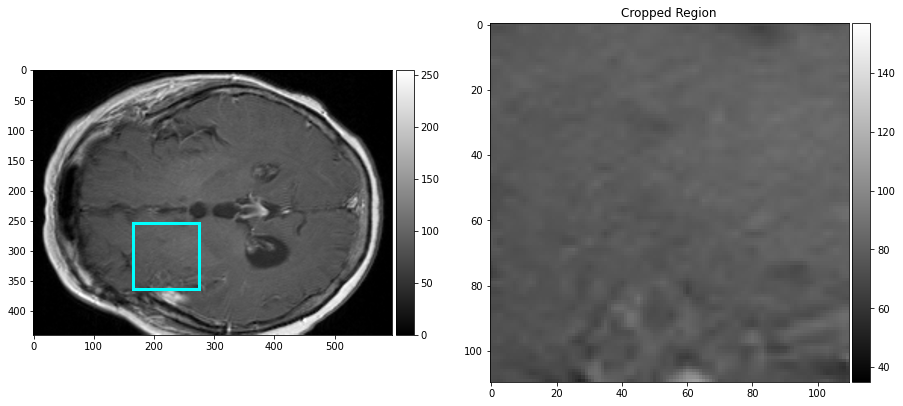

In [8]:
cropped_array = highlight_rectangle_on_image(img_array, mask_min_x, mask_min_y, patch_window_size, patch_window_size)

In [9]:
cropped_padded_array = img_array[mask_min_x - int(haralick_window_size / 2):mask_min_x + patch_window_size + int(haralick_window_size / 2), mask_min_y - int(haralick_window_size / 2):mask_min_y + patch_window_size + int(haralick_window_size / 2)]

Text(0.5, 1.0, 'dy')

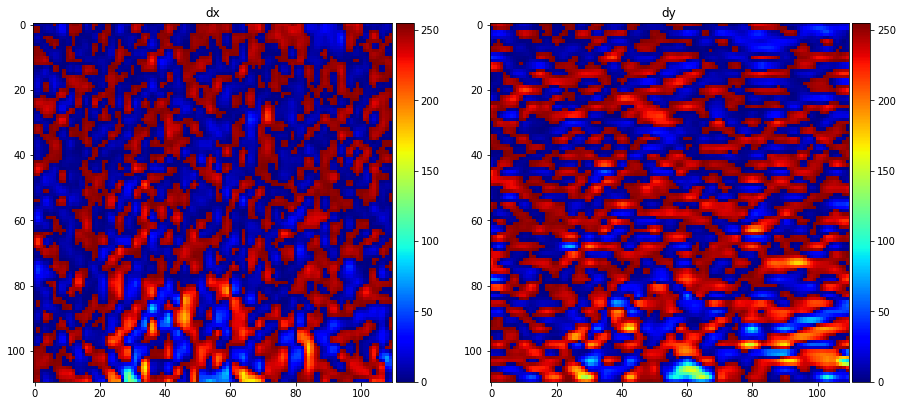

In [10]:
figure, axes = plt.subplots(1, 2, figsize=(15, 15))

# Define kernel for x differences.
kernel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

# Define kernel for y differences.
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Perform x convolution.
dx=ndimage.convolve(cropped_array[:, :, 0], kernel_x)

# Perform y convolution.
dy=ndimage.convolve(cropped_array[:, :, 0], kernel_y)

# Display dx & dy.
show_colored_image(figure, axes[0], dx)
axes[0].set_title('dx')
show_colored_image(figure, axes[1], dy)
axes[1].set_title('dy')

Creating windows:
Creating windows done.
Center x,y = 80, 71
dx Patch for Haralick:


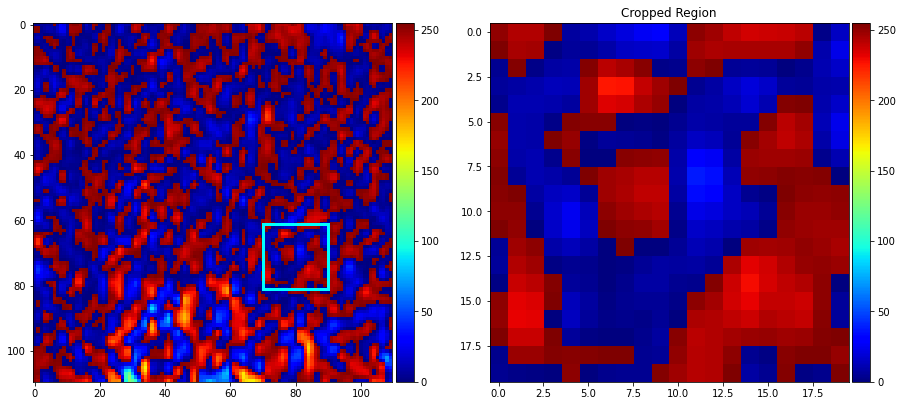

dy Patch for Haralick:


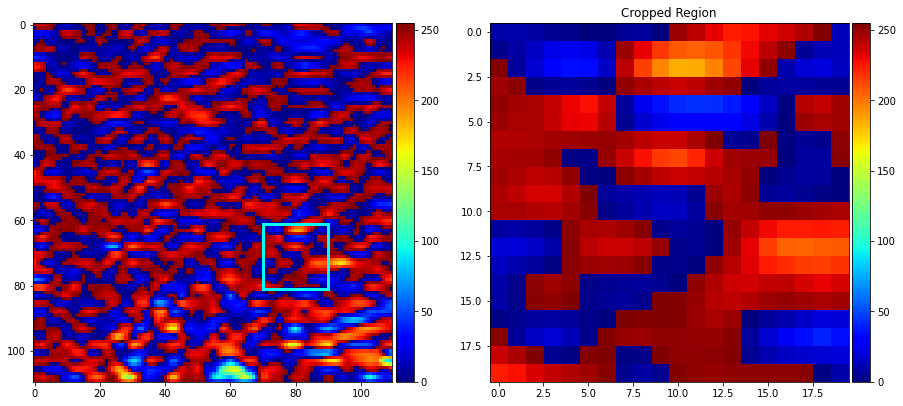

array([[  9,  10,   8,   5,   3,   0,   0,   5,   6,   0, 249, 242, 232,
        225, 227, 232, 237, 244, 254,  13],
       [  3,   8,  15,  23,  26,  23,  11, 249, 232, 217, 208, 206, 209,
        218, 230, 242, 252,   5,  12,  13],
       [254,   6,  18,  28,  35,  34,  16, 242, 215, 196, 185, 186, 197,
        213, 232, 251,  10,  19,  21,  14],
       [248, 252,   2,   5,   6,   4,   0, 251, 246, 242, 239, 242, 248,
        251,   0,   6,   8,   7,   5,   4],
       [251, 247, 245, 240, 231, 228, 240,   6,  25,  36,  42,  44,  43,
         38,  28,  15,   0, 243, 240, 248],
       [249, 246, 245, 240, 232, 231, 243,   4,  17,  24,  28,  31,  32,
         30,  22,  10,   0, 249, 246, 248],
       [244, 244, 245, 247, 248, 249, 250, 247, 242, 239, 239, 245, 255,
          5,   3, 255,   1,   5,   3, 252],
       [246, 247, 247, 251,   1,   2, 250, 239, 228, 217, 213, 222, 238,
        248, 249, 250,   0,   7,   7, 253],
       [248, 245, 241, 243, 251,   1,   0, 252, 247, 241, 238, 2

In [11]:
# Create windows.
print('Creating windows:')
dx_windows = view_as_windows(dx, (haralick_window_size, haralick_window_size))
dy_windows = view_as_windows(dy, (haralick_window_size, haralick_window_size))
print('Creating windows done.')

# Extract a random patch
haralick_center_x = random.randint(int(haralick_window_size/2),dx_windows.shape[1]-int(haralick_window_size/2))
haralick_center_y = random.randint(int(haralick_window_size/2),dx_windows.shape[1]-int(haralick_window_size/2))

print(f'Center x,y = {haralick_center_x}, {haralick_center_y}')

# Get window at x,y.
dx_patch = dx_windows[haralick_center_y, haralick_center_x]
dy_patch = dy_windows[haralick_center_y, haralick_center_x]

# Display windows.
haralick_min_x = haralick_center_x - int(haralick_window_size/2)
haralick_min_y = haralick_center_y - int(haralick_window_size/2)
print('dx Patch for Haralick:')
highlight_rectangle_on_image(dx, haralick_min_x, haralick_min_y, haralick_window_size, haralick_window_size, plt.cm.jet)
print('dy Patch for Haralick:')
highlight_rectangle_on_image(dy, haralick_min_x, haralick_min_y, haralick_window_size, haralick_window_size, plt.cm.jet)

In [12]:
def svd_dominant_angle(x, y, dx_windows, dy_windows, window_size):
    dx_patch = dx_windows[y, x]
    dy_patch = dy_windows[y, x]
    window_area = window_size * window_size
    flattened_gradients = np.zeros((window_area, 2))
    #print(f'Flattened gradients shape = {flattened_gradients.shape}')
    flattened_gradients[:,0] = np.reshape(dx_patch, ((window_area)))
    flattened_gradients[:,1] = np.reshape(dy_patch, ((window_area)))
    #print('Calculating svd...', flush=True)
    U, S, V = linalg.svd(flattened_gradients)
    #print('Calculating svd done.', flush=True)
    #print(f'V (from SVD) = \n{V}')
    dominant_angle = math.atan2(V[0, 0], V[0, 1])
    #print(f'Dominant angle = atan2({V[0, 0]}/{V[0, 1]})={dominant_angle}')
    return dominant_angle

Calculating svd:
Calculating svd done.


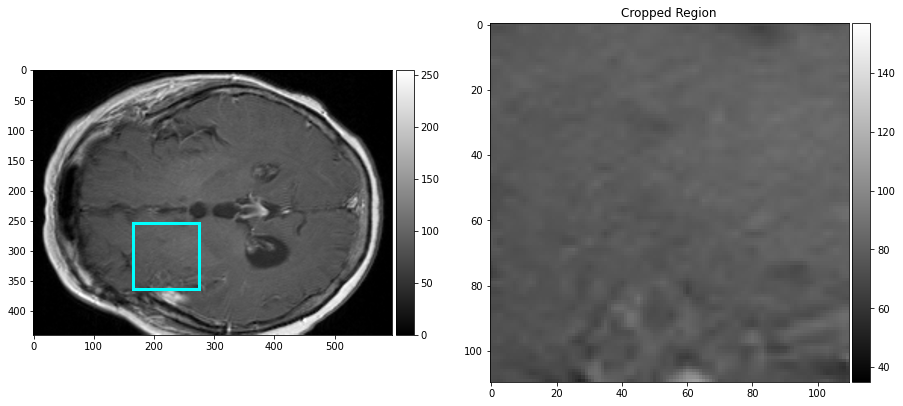

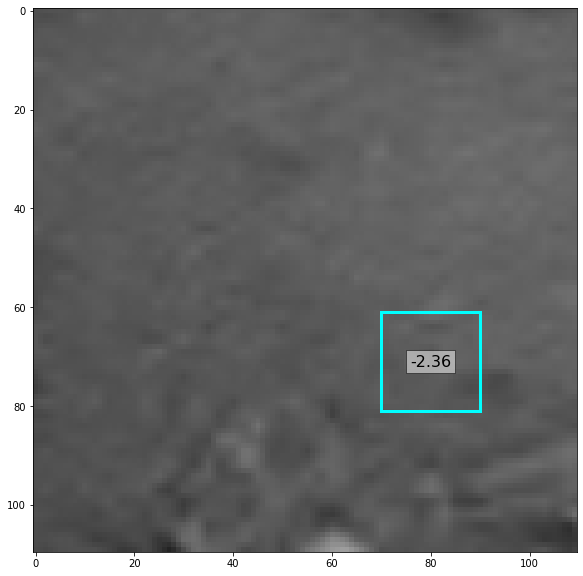

In [13]:
print('Calculating svd:')
dominant_angle = svd_dominant_angle(haralick_center_x, haralick_center_y, dx_windows, dy_windows, haralick_window_size)
print('Calculating svd done.')

# Show highlighted region.
highlight_rectangle_on_image(img_array, mask_min_x, mask_min_y, patch_window_size, patch_window_size)

# Overlay dominant angle on top of window.
figure, axis = plt.subplots(1, 1, figsize=(10, 10))
image_patch_array = img_array[mask_min_y:mask_max_y, mask_min_x:mask_max_x]
axis.imshow(image_patch_array, cmap=plt.cm.gray)
axis.add_patch(create_highlighted_rectangle(haralick_min_x, haralick_min_y, haralick_window_size, haralick_window_size))
axis.text(haralick_min_x + haralick_window_size / 2, haralick_min_y + haralick_window_size / 2, round(dominant_angle, 2), fontsize=16, horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [14]:
def arrow_for_window(window_array, center_x, center_y, window_size, dominant_angle):
    arrow_dx = math.cos(dominant_angle) * window_size / 1.1
    arrow_dy = math.sin(dominant_angle) * window_size / 1.1 * -1
    arrow_x = center_x
    arrow_y = center_y
#     print(f'x={arrow_x} y={arrow_y} dx={arrow_dx} dy={arrow_dy}')
    return mpatches.Arrow(arrow_x, arrow_y, arrow_dx, arrow_dy, width=window_size / 2, color='orange')

In [15]:
def show_arrow_on_window(window_array, center_x, center_y, window_size, dominant_angle):
    fig, ax = plt.subplots(1)
    ax.imshow(window_array, cmap=plt.cm.gray)
    ax.add_patch(arrow_for_window(window_array, center_x, center_y, window_size, dominant_angle))
    plt.show()

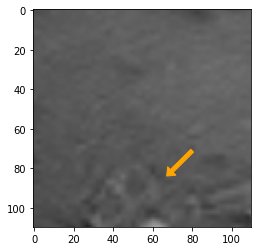

In [16]:
show_arrow_on_window(cropped_array, haralick_center_x, haralick_center_y, haralick_window_size, dominant_angle)

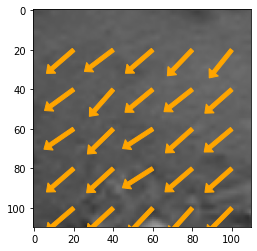

In [17]:
fig, ax = plt.subplots(1)
ax.imshow(cropped_array, cmap=plt.cm.gray)
half_window = int(haralick_window_size / 2)
for x in range(0, dx_windows.shape[0] - half_window, haralick_window_size):
    for y in range(0, dy_windows.shape[1] - half_window, haralick_window_size):
        dominant_angle = svd_dominant_angle(x + half_window, y + half_window, dx_windows, dy_windows, haralick_window_size)
        ax.add_patch(arrow_for_window(cropped_array, x + haralick_window_size, y + haralick_window_size, haralick_window_size, dominant_angle))
plt.show()

In [18]:
haralick_image = np.zeros(cropped_array.shape, dtype=np.uint8)

In [19]:
def get_haralick(sitk_image, img_array, x, y, window_size, haralick_feature):
    haralick_mask = np.full(img_array.shape, 0)
    haralick_mask[x:x + window_size, y:y + window_size] = [1, 1, 1]
    sitk_mask = sitk.GetImageFromArray(haralick_mask)
    haralick = RadiomicsGLCM(sitk_image, sitk_mask)
    haralick.enableFeatureByName(haralick_feature.value[0])
    haralick.execute()
    return haralick_feature.value[1](haralick)[0]

In [20]:
sitk_cropped_image = sitk.GetImageFromArray(cropped_array)
cropped_image_mask_array = np.full(img_array.shape, 0)
h, w, a = cropped_array.shape
for pos in product(range(h), range(w)):
   result = get_haralick(sitk_cropped_image, cropped_array, pos[0], pos[1], haralick_window_size, desired_haralick_feature)
   haralick_image[pos[0], pos[1]] = [int(result * 255), int(result * 255), int(result * 255)]

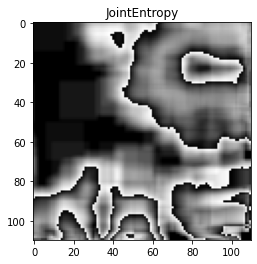

In [21]:
plt.title(desired_haralick_feature.value[0])
plt.imshow(haralick_image, cmap=plt.cm.jet)